Carhart 4-Factor Model Implementation

1. Generating sample data...
Generated 60 months of data for 5 sample assets

Sample Factor Data:
        Date  Market_Premium       SMB       HML       WML  Risk_Free
0 2019-01-31        3.035214 -1.237523  3.068612  3.002669  -0.196260
1 2019-02-28        0.177811 -0.356977 -2.882856 -2.928630   0.142632
2 2019-03-31        3.714598 -3.119005  5.209780 -3.783570   0.452494
3 2019-04-30        7.653634 -3.388620 -4.606479  2.429890   0.632878
4 2019-05-31       -0.253690  2.637577  2.354000 -0.393851  -0.400148

2. Calculating excess returns...

3. Running Carhart 4-factor regressions...

4. Regression Results:
Carhart 4-Factor Model Results
Coefficients shown as: Estimate (t-statistic)
--------------------------------------------------------------------------------
        Asset           Alpha    Market_Beta        SMB_Beta         HML_Beta        WML_Beta R_squared
 Large_Growth   0.1121 (0.58) 1.1121 (23.68) -0.5241 (-7.57) -0.9074 (-16.14) -

C:\Users\mohxm\AppData\Local\Temp\ipykernel_24344\174227030.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2019-01-01', periods=n_periods, freq='M')


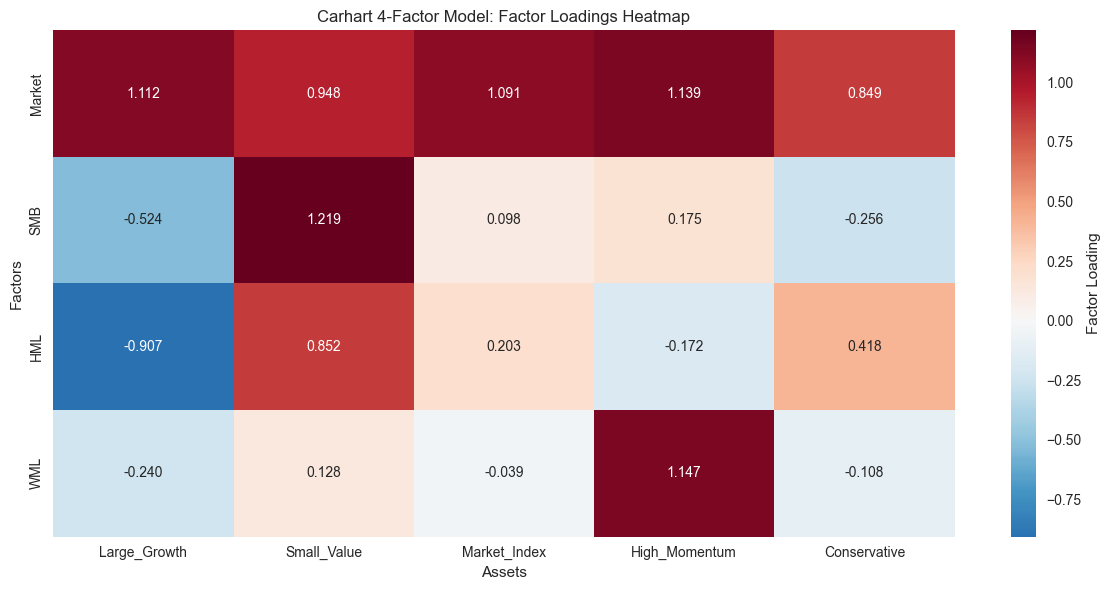

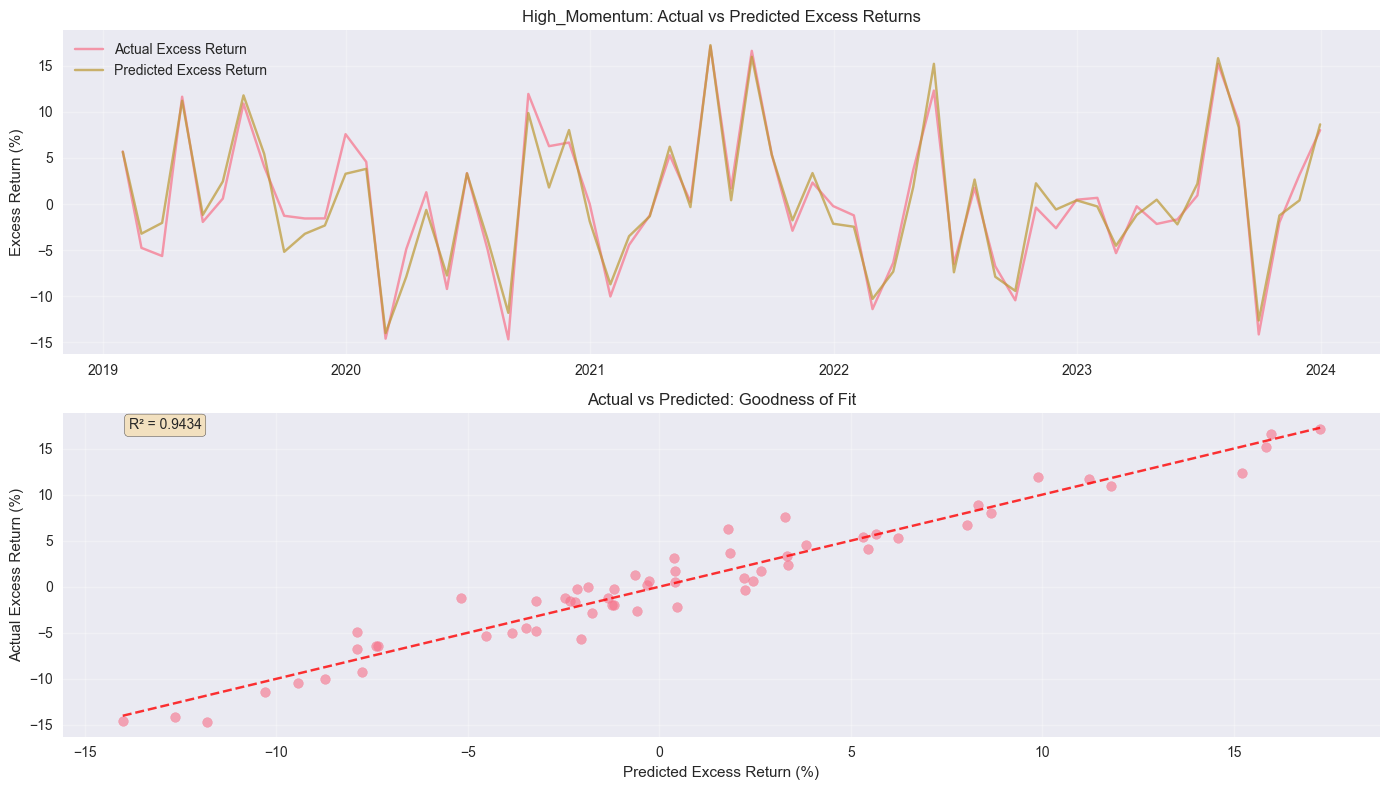


Interpretation Guide:
--------------------------------------------------
Alpha: Risk-adjusted return (ideally close to 0 for efficient pricing)
Market Beta: Sensitivity to overall market movements
SMB Beta: Exposure to small-cap vs large-cap stocks
HML Beta: Exposure to value vs growth stocks
WML Beta: Exposure to momentum vs contrarian strategies

t-statistics > |2| are generally considered statistically significant


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from datetime import datetime, timedelta

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class Carhart4FactorModel:
    """
    Implementation of the Carhart 4-Factor Model
    
    The model extends Fama-French 3-factor model with momentum:
    R(i,t) - RF(t) = α + β₁[RM(t) - RF(t)] + β₂SMB(t) + β₃HML(t) + β₄WML(t) + ε(i,t)
    
    Where:
    - R(i,t): Return on security/portfolio i in period t
    - RF(t): Risk-free rate in period t
    - RM(t): Return on market portfolio in period t
    - SMB(t): Small Minus Big (size factor)
    - HML(t): High Minus Low (value factor)  
    - WML(t): Winners Minus Losers (momentum factor)
    """
    
    def __init__(self):
        self.coefficients = {}
        self.statistics = {}
        self.factor_data = None
        self.excess_returns = None
        
    def generate_sample_data(self, n_periods=60, n_assets=5):
        """
        Generate sample factor data and asset returns for demonstration
        """
        np.random.seed(42)  # For reproducibility
        
        # Generate dates
        dates = pd.date_range(start='2019-01-01', periods=n_periods, freq='M')
        
        # Generate factor returns (monthly %)
        # Market premium: typically 0.5-1% monthly with volatility
        market_premium = np.random.normal(0.8, 4.5, n_periods)
        
        # SMB factor: small cap premium, typically smaller and more volatile
        smb = np.random.normal(0.2, 3.0, n_periods)
        
        # HML factor: value premium, historically positive but volatile
        hml = np.random.normal(0.3, 3.5, n_periods)
        
        # WML factor: momentum premium, can be quite volatile
        wml = np.random.normal(0.5, 4.0, n_periods)
        
        # Risk-free rate: typically low, around 0.1-0.3% monthly
        risk_free = np.random.normal(0.2, 0.5, n_periods)
        
        # Create factor dataframe
        self.factor_data = pd.DataFrame({
            'Date': dates,
            'Market_Premium': market_premium,
            'SMB': smb,
            'HML': hml,
            'WML': wml,
            'Risk_Free': risk_free
        })
        
        # Generate asset returns based on different factor loadings
        asset_returns = {}
        factor_loadings = {
            'Large_Growth': [1.2, -0.5, -0.8, -0.3],  # Large cap, growth, contrarian
            'Small_Value': [1.0, 1.2, 0.9, 0.2],      # Small cap, value, slight momentum
            'Market_Index': [1.0, 0.1, 0.1, 0.0],     # Market-like exposure
            'High_Momentum': [1.1, 0.3, -0.2, 1.2],   # Strong momentum tilt
            'Conservative': [0.7, -0.2, 0.4, -0.1]    # Low beta, defensive
        }
        
        for asset_name, loadings in factor_loadings.items():
            # Generate returns using the factor model plus idiosyncratic risk
            returns = (risk_free + 
                      loadings[0] * market_premium +
                      loadings[1] * smb +
                      loadings[2] * hml +
                      loadings[3] * wml +
                      np.random.normal(0, 2.0, n_periods))  # Idiosyncratic risk
            
            asset_returns[asset_name] = returns
        
        # Add asset returns to factor data
        for asset_name, returns in asset_returns.items():
            self.factor_data[f'{asset_name}_Return'] = returns
            
        return self.factor_data
    
    def calculate_excess_returns(self, asset_columns=None):
        """
        Calculate excess returns (asset return - risk-free rate)
        """
        if asset_columns is None:
            # Auto-detect asset columns (those ending with '_Return')
            asset_columns = [col for col in self.factor_data.columns if col.endswith('_Return')]
        
        excess_returns = {}
        for col in asset_columns:
            asset_name = col.replace('_Return', '')
            excess_returns[f'{asset_name}_Excess'] = (
                self.factor_data[col] - self.factor_data['Risk_Free']
            )
        
        self.excess_returns = pd.DataFrame(excess_returns, index=self.factor_data.index)
        return self.excess_returns
    
    def run_regression(self, asset_name):
        """
        Run Carhart 4-factor regression for a specific asset
        """
        if self.excess_returns is None:
            self.calculate_excess_returns()
        
        # Prepare data
        y = self.excess_returns[f'{asset_name}_Excess'].values
        X = self.factor_data[['Market_Premium', 'SMB', 'HML', 'WML']].values
        
        # Add constant for alpha
        X_with_const = np.column_stack([np.ones(len(X)), X])
        
        # Run regression
        model = LinearRegression(fit_intercept=False)  # We added constant manually
        model.fit(X_with_const, y)
        
        # Calculate statistics
        y_pred = model.predict(X_with_const)
        residuals = y - y_pred
        
        # R-squared
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Standard errors (simplified calculation)
        mse = ss_res / (len(y) - len(model.coef_))
        var_coef = mse * np.linalg.inv(X_with_const.T @ X_with_const).diagonal()
        std_errors = np.sqrt(var_coef)
        
        # T-statistics
        t_stats = model.coef_ / std_errors
        
        # Store results
        self.coefficients[asset_name] = {
            'Alpha': model.coef_[0],
            'Beta_Market': model.coef_[1],
            'Beta_SMB': model.coef_[2],
            'Beta_HML': model.coef_[3],
            'Beta_WML': model.coef_[4]
        }
        
        self.statistics[asset_name] = {
            'R_squared': r_squared,
            'Std_Errors': {
                'Alpha': std_errors[0],
                'Market': std_errors[1],
                'SMB': std_errors[2],
                'HML': std_errors[3],
                'WML': std_errors[4]
            },
            'T_Statistics': {
                'Alpha': t_stats[0],
                'Market': t_stats[1],
                'SMB': t_stats[2],
                'HML': t_stats[3],
                'WML': t_stats[4]
            }
        }
        
        return self.coefficients[asset_name], self.statistics[asset_name]
    
    def run_all_regressions(self):
        """
        Run regressions for all assets
        """
        if self.excess_returns is None:
            self.calculate_excess_returns()
        
        results = {}
        for col in self.excess_returns.columns:
            asset_name = col.replace('_Excess', '')
            results[asset_name] = self.run_regression(asset_name)
        
        return results
    
    def display_results(self, asset_name=None):
        """
        Display regression results in a formatted table
        """
        if asset_name:
            assets_to_show = [asset_name]
        else:
            assets_to_show = list(self.coefficients.keys())
        
        # Create results dataframe
        results_data = []
        for asset in assets_to_show:
            if asset in self.coefficients:
                coef = self.coefficients[asset]
                stats = self.statistics[asset]
                
                results_data.append({
                    'Asset': asset,
                    'Alpha': f"{coef['Alpha']:.4f} ({stats['T_Statistics']['Alpha']:.2f})",
                    'Market_Beta': f"{coef['Beta_Market']:.4f} ({stats['T_Statistics']['Market']:.2f})",
                    'SMB_Beta': f"{coef['Beta_SMB']:.4f} ({stats['T_Statistics']['SMB']:.2f})",
                    'HML_Beta': f"{coef['Beta_HML']:.4f} ({stats['T_Statistics']['HML']:.2f})",
                    'WML_Beta': f"{coef['Beta_WML']:.4f} ({stats['T_Statistics']['WML']:.2f})",
                    'R_squared': f"{stats['R_squared']:.4f}"
                })
        
        results_df = pd.DataFrame(results_data)
        print("Carhart 4-Factor Model Results")
        print("=" * 80)
        print("Coefficients shown as: Estimate (t-statistic)")
        print("-" * 80)
        print(results_df.to_string(index=False))
        
        return results_df
    
    def plot_factor_loadings(self):
        """
        Create a heatmap of factor loadings
        """
        if not self.coefficients:
            print("No regression results available. Run regressions first.")
            return
        
        # Prepare data for heatmap
        factors = ['Beta_Market', 'Beta_SMB', 'Beta_HML', 'Beta_WML']
        factor_names = ['Market', 'SMB', 'HML', 'WML']
        
        loadings_data = []
        assets = list(self.coefficients.keys())
        
        for factor in factors:
            loadings_data.append([self.coefficients[asset][factor] for asset in assets])
        
        loadings_df = pd.DataFrame(loadings_data, 
                                 index=factor_names, 
                                 columns=assets)
        
        # Create heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(loadings_df, annot=True, cmap='RdBu_r', center=0, 
                   fmt='.3f', cbar_kws={'label': 'Factor Loading'})
        plt.title('Carhart 4-Factor Model: Factor Loadings Heatmap')
        plt.xlabel('Assets')
        plt.ylabel('Factors')
        plt.tight_layout()
        plt.show()
    
    def plot_time_series(self, asset_name):
        """
        Plot actual vs predicted returns for an asset
        """
        if asset_name not in self.coefficients:
            print(f"No regression results for {asset_name}")
            return
        
        # Calculate predicted returns
        coef = self.coefficients[asset_name]
        factors = self.factor_data[['Market_Premium', 'SMB', 'HML', 'WML']]
        
        predicted_excess = (coef['Alpha'] + 
                           coef['Beta_Market'] * factors['Market_Premium'] +
                           coef['Beta_SMB'] * factors['SMB'] +
                           coef['Beta_HML'] * factors['HML'] +
                           coef['Beta_WML'] * factors['WML'])
        
        actual_excess = self.excess_returns[f'{asset_name}_Excess']
        
        # Plot
        plt.figure(figsize=(14, 8))
        
        # Time series plot
        plt.subplot(2, 1, 1)
        plt.plot(self.factor_data['Date'], actual_excess, label='Actual Excess Return', alpha=0.7)
        plt.plot(self.factor_data['Date'], predicted_excess, label='Predicted Excess Return', alpha=0.7)
        plt.title(f'{asset_name}: Actual vs Predicted Excess Returns')
        plt.ylabel('Excess Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Scatter plot
        plt.subplot(2, 1, 2)
        plt.scatter(predicted_excess, actual_excess, alpha=0.6)
        plt.plot([min(predicted_excess), max(predicted_excess)], 
                [min(predicted_excess), max(predicted_excess)], 'r--', alpha=0.8)
        plt.xlabel('Predicted Excess Return (%)')
        plt.ylabel('Actual Excess Return (%)')
        plt.title('Actual vs Predicted: Goodness of Fit')
        plt.grid(True, alpha=0.3)
        
        # Add R² to the plot
        r_sq = self.statistics[asset_name]['R_squared']
        plt.text(0.05, 0.95, f'R² = {r_sq:.4f}', transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

# Example usage and demonstration
def main():
    print("Carhart 4-Factor Model Implementation")
    print("=" * 50)
    
    # Initialize model
    model = Carhart4FactorModel()
    
    # Generate sample data
    print("\n1. Generating sample data...")
    factor_data = model.generate_sample_data(n_periods=60)
    print(f"Generated {len(factor_data)} months of data for 5 sample assets")
    
    # Show first few rows of factor data
    print("\nSample Factor Data:")
    print(factor_data[['Date', 'Market_Premium', 'SMB', 'HML', 'WML', 'Risk_Free']].head())
    
    # Calculate excess returns
    print("\n2. Calculating excess returns...")
    excess_returns = model.calculate_excess_returns()
    
    # Run regressions
    print("\n3. Running Carhart 4-factor regressions...")
    results = model.run_all_regressions()
    
    # Display results
    print("\n4. Regression Results:")
    model.display_results()
    
    # Create visualizations
    print("\n5. Creating visualizations...")
    
    # Factor loadings heatmap
    model.plot_factor_loadings()
    
    # Time series plot for one asset
    model.plot_time_series('High_Momentum')
    
    print("\nInterpretation Guide:")
    print("-" * 50)
    print("Alpha: Risk-adjusted return (ideally close to 0 for efficient pricing)")
    print("Market Beta: Sensitivity to overall market movements")
    print("SMB Beta: Exposure to small-cap vs large-cap stocks")
    print("HML Beta: Exposure to value vs growth stocks") 
    print("WML Beta: Exposure to momentum vs contrarian strategies")
    print("\nt-statistics > |2| are generally considered statistically significant")

if __name__ == "__main__":
    main()

Fama-French 5-Factor Model Implementation

1. Generating sample data...


C:\Users\mohxm\AppData\Local\Temp\ipykernel_24344\3632464825.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2019-01-01', periods=n_periods, freq='M')


Generated 60 months of data for 6 sample assets

Sample Factor Data:
        Date  Market_Premium       SMB       HML       RMW       CMA  \
0 2019-01-31        3.035214 -1.237523  2.781302  2.051869 -1.631302   
1 2019-02-28        0.177811 -0.356977 -2.660040 -2.100041  0.063159   
2 2019-03-31        3.714598 -3.119005  4.738942 -2.698499  1.612468   
3 2019-04-30        7.653634 -3.388620 -4.235923  1.650923  2.514388   
4 2019-05-31       -0.253690  2.637577  2.127943 -0.325696 -2.650741   

   Risk_Free  
0  -0.214498  
1  -0.080091  
2   0.573647  
3   0.505185  
4   0.189549  

2. Calculating excess returns...

3. Running Fama-French 5-factor regressions...

4. Regression Results:
Fama-French 5-Factor Model Results
Coefficients shown as: Estimate (t-statistic)
------------------------------------------------------------------------------------------------------------------------
                  Asset           Alpha       Market_β           SMB_β            HML_β           RM

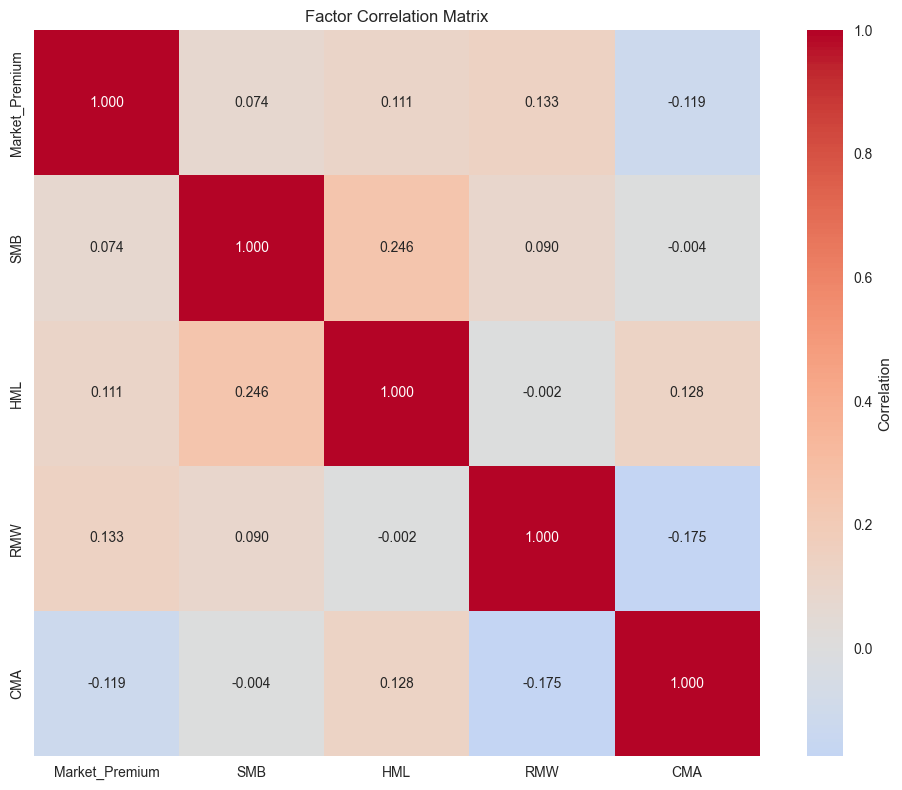

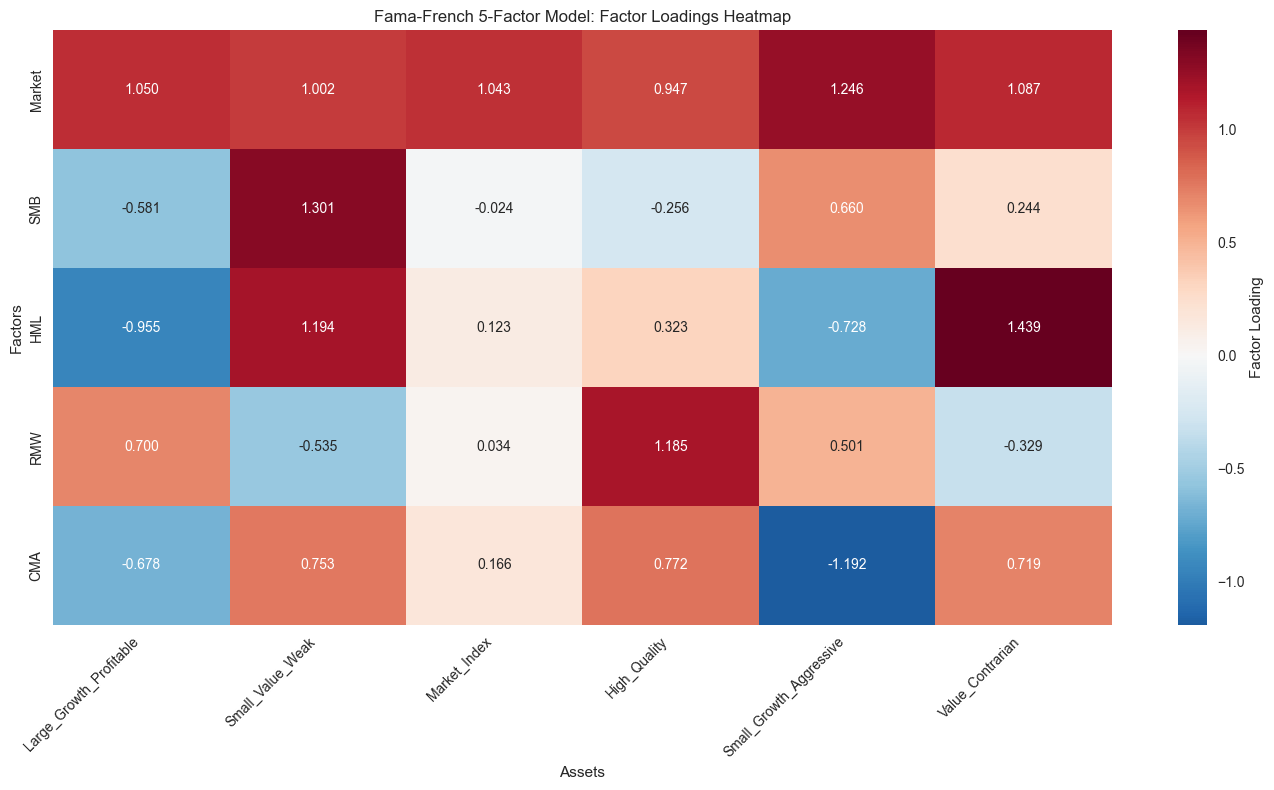

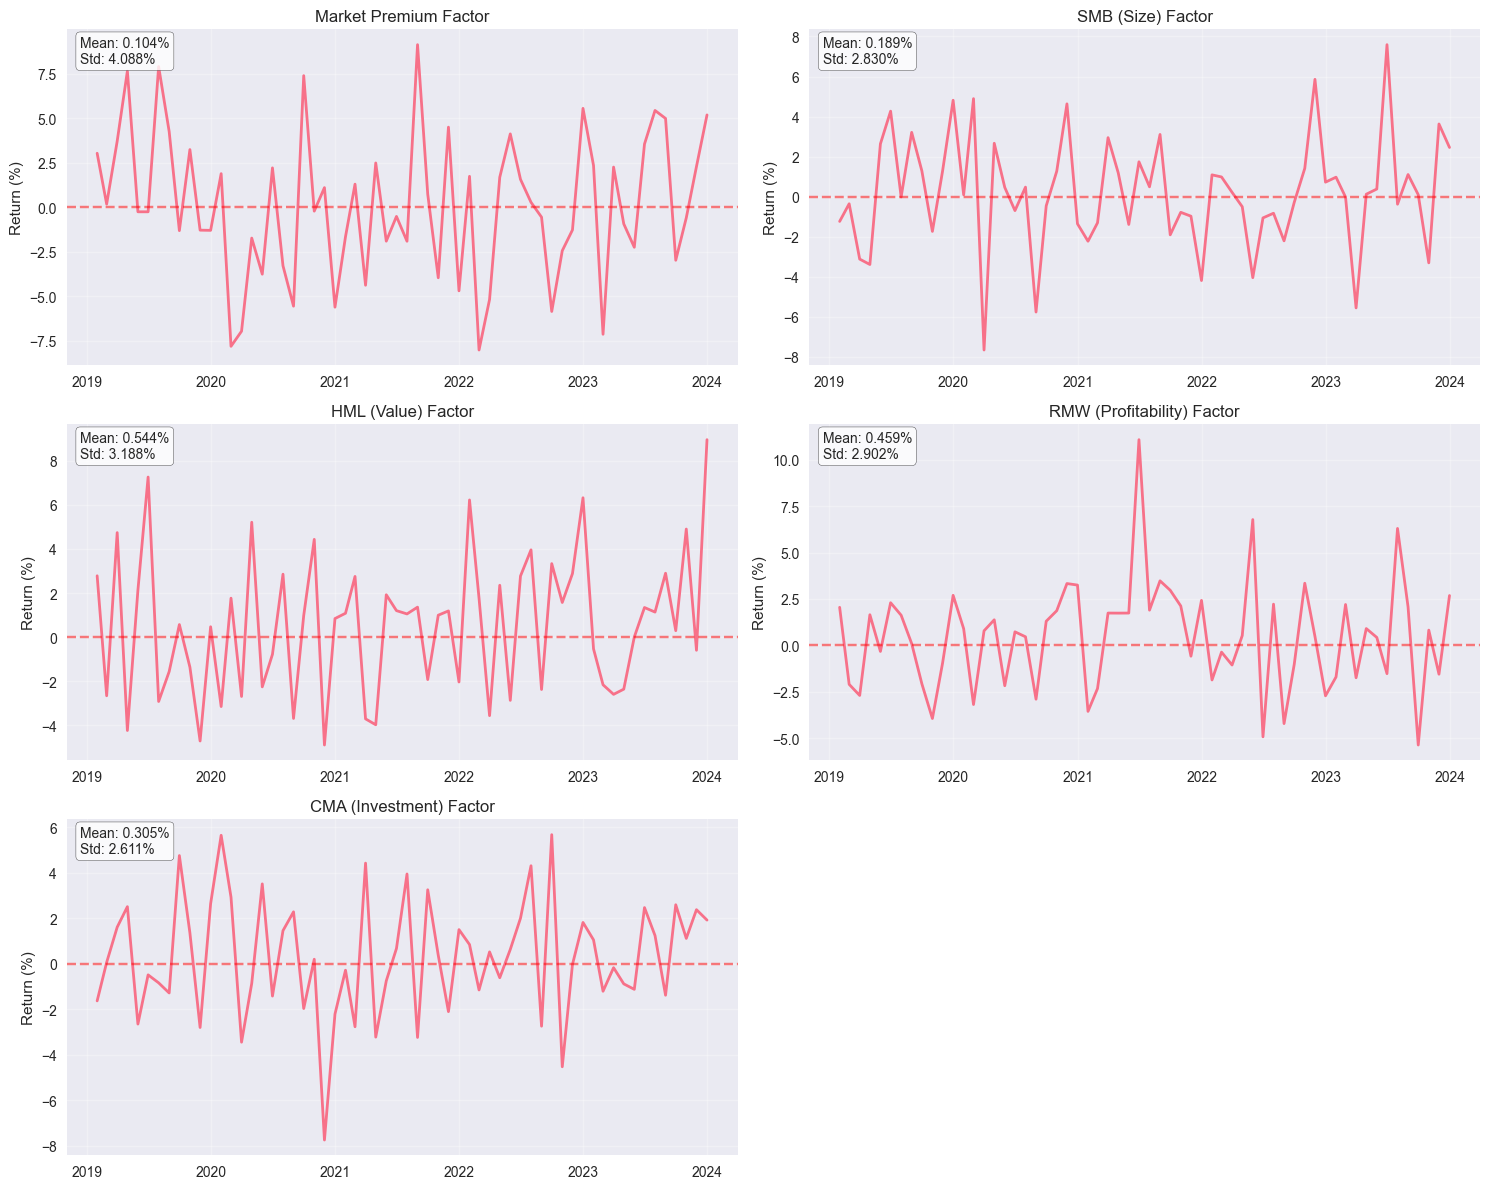

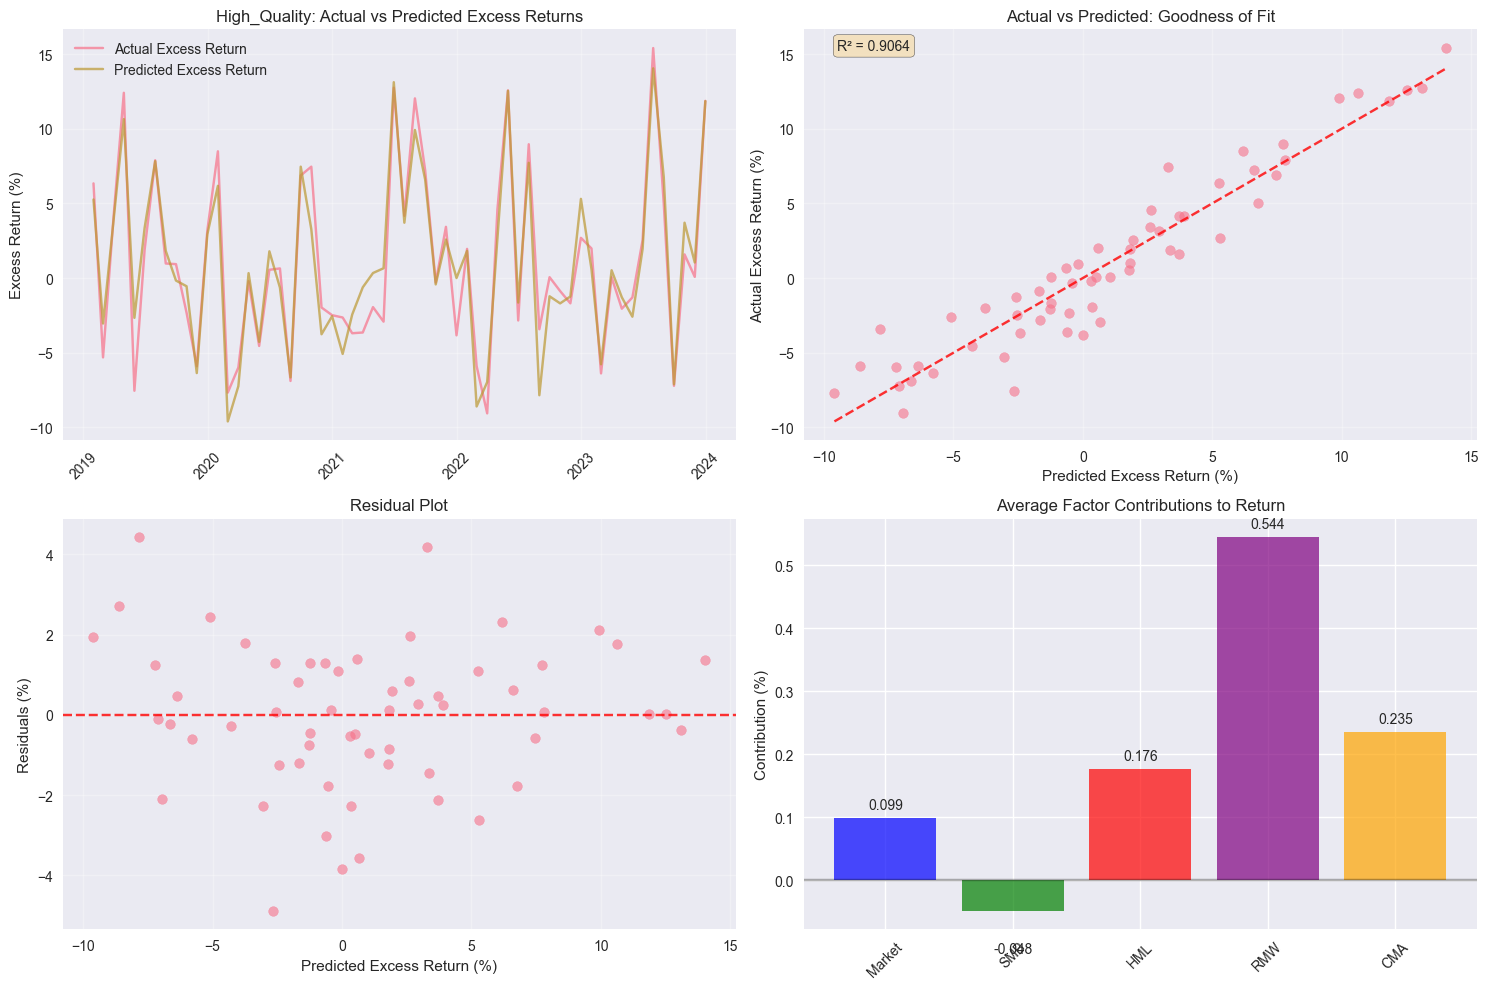


FACTOR INTERPRETATION GUIDE
Alpha: Risk-adjusted abnormal return (should be ≈0 for efficient pricing)
Market Beta: Sensitivity to overall market movements
SMB Beta: Small-cap (+) vs Large-cap (-) exposure
HML Beta: Value (+) vs Growth (-) exposure
RMW Beta: Robust/Profitable (+) vs Weak (-) profitability exposure
CMA Beta: Conservative/Low Investment (+) vs Aggressive/High Investment (-)

Statistical Significance:
- t-statistics > |2| are generally considered significant
- Higher R² indicates better model fit
- 5-factor model typically explains more variation than 3-factor model


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from datetime import datetime, timedelta

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class FamaFrench5FactorModel:
    """
    Implementation of the Fama-French 5-Factor Model
    
    The model equation:
    R(i,t) - RF(t) = α + β₁[RM(t) - RF(t)] + β₂SMB(t) + β₃HML(t) + β₄RMW(t) + β₅CMA(t) + ε(i,t)
    
    Where:
    - R(i,t): Return on security/portfolio i in period t
    - RF(t): Risk-free rate in period t
    - RM(t): Return on market portfolio in period t
    - SMB(t): Small Minus Big (size factor)
    - HML(t): High Minus Low (value factor)
    - RMW(t): Robust Minus Weak (profitability factor)
    - CMA(t): Conservative Minus Aggressive (investment factor)
    """
    
    def __init__(self):
        self.coefficients = {}
        self.statistics = {}
        self.factor_data = None
        self.excess_returns = None
        
    def generate_sample_data(self, n_periods=60, n_assets=6):
        """
        Generate sample factor data and asset returns for demonstration
        """
        np.random.seed(42)  # For reproducibility
        
        # Generate dates
        dates = pd.date_range(start='2019-01-01', periods=n_periods, freq='M')
        
        # Generate factor returns (monthly %)
        # Market premium: typically 0.5-1% monthly with volatility
        market_premium = np.random.normal(0.8, 4.5, n_periods)
        
        # SMB factor: small cap premium, typically smaller and more volatile
        smb = np.random.normal(0.2, 3.0, n_periods)
        
        # HML factor: value premium, historically positive but declining
        hml = np.random.normal(0.25, 3.2, n_periods)
        
        # RMW factor: profitability premium, typically positive
        rmw = np.random.normal(0.3, 2.8, n_periods)
        
        # CMA factor: investment factor, typically positive (conservative > aggressive)
        cma = np.random.normal(0.35, 2.5, n_periods)
        
        # Risk-free rate: typically low, around 0.1-0.3% monthly
        risk_free = np.random.normal(0.2, 0.5, n_periods)
        
        # Create factor dataframe
        self.factor_data = pd.DataFrame({
            'Date': dates,
            'Market_Premium': market_premium,
            'SMB': smb,
            'HML': hml,
            'RMW': rmw,
            'CMA': cma,
            'Risk_Free': risk_free
        })
        
        # Generate asset returns based on different factor loadings
        asset_returns = {}
        factor_loadings = {
            'Large_Growth_Profitable': [1.1, -0.6, -0.9, 0.8, -0.7],    # Large, growth, profitable, aggressive
            'Small_Value_Weak': [0.9, 1.3, 1.1, -0.5, 0.6],            # Small, value, weak profitability, conservative
            'Market_Index': [1.0, 0.1, 0.1, 0.1, 0.1],                 # Market-like exposure
            'High_Quality': [0.8, -0.2, 0.3, 1.2, 0.8],                # Low beta, profitable, conservative
            'Small_Growth_Aggressive': [1.2, 0.9, -0.8, 0.4, -1.0],    # Small, growth, aggressive investment
            'Value_Contrarian': [1.0, 0.3, 1.4, -0.3, 0.9]             # Value tilt, conservative
        }
        
        for asset_name, loadings in factor_loadings.items():
            # Generate returns using the factor model plus idiosyncratic risk
            returns = (risk_free + 
                      loadings[0] * market_premium +
                      loadings[1] * smb +
                      loadings[2] * hml +
                      loadings[3] * rmw +
                      loadings[4] * cma +
                      np.random.normal(0, 2.0, n_periods))  # Idiosyncratic risk
            
            asset_returns[asset_name] = returns
        
        # Add asset returns to factor data
        for asset_name, returns in asset_returns.items():
            self.factor_data[f'{asset_name}_Return'] = returns
            
        return self.factor_data
    
    def calculate_excess_returns(self, asset_columns=None):
        """
        Calculate excess returns (asset return - risk-free rate)
        """
        if asset_columns is None:
            # Auto-detect asset columns (those ending with '_Return')
            asset_columns = [col for col in self.factor_data.columns if col.endswith('_Return')]
        
        excess_returns = {}
        for col in asset_columns:
            asset_name = col.replace('_Return', '')
            excess_returns[f'{asset_name}_Excess'] = (
                self.factor_data[col] - self.factor_data['Risk_Free']
            )
        
        self.excess_returns = pd.DataFrame(excess_returns, index=self.factor_data.index)
        return self.excess_returns
    
    def run_regression(self, asset_name):
        """
        Run Fama-French 5-factor regression for a specific asset
        """
        if self.excess_returns is None:
            self.calculate_excess_returns()
        
        # Prepare data
        y = self.excess_returns[f'{asset_name}_Excess'].values
        X = self.factor_data[['Market_Premium', 'SMB', 'HML', 'RMW', 'CMA']].values
        
        # Add constant for alpha
        X_with_const = np.column_stack([np.ones(len(X)), X])
        
        # Run regression
        model = LinearRegression(fit_intercept=False)  # We added constant manually
        model.fit(X_with_const, y)
        
        # Calculate statistics
        y_pred = model.predict(X_with_const)
        residuals = y - y_pred
        
        # R-squared
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Adjusted R-squared
        n = len(y)
        k = len(model.coef_) - 1  # Number of predictors (excluding constant)
        adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
        
        # Standard errors (simplified calculation)
        mse = ss_res / (len(y) - len(model.coef_))
        var_coef = mse * np.linalg.inv(X_with_const.T @ X_with_const).diagonal()
        std_errors = np.sqrt(var_coef)
        
        # T-statistics
        t_stats = model.coef_ / std_errors
        
        # Store results
        self.coefficients[asset_name] = {
            'Alpha': model.coef_[0],
            'Beta_Market': model.coef_[1],
            'Beta_SMB': model.coef_[2],
            'Beta_HML': model.coef_[3],
            'Beta_RMW': model.coef_[4],
            'Beta_CMA': model.coef_[5]
        }
        
        self.statistics[asset_name] = {
            'R_squared': r_squared,
            'Adj_R_squared': adj_r_squared,
            'Std_Errors': {
                'Alpha': std_errors[0],
                'Market': std_errors[1],
                'SMB': std_errors[2],
                'HML': std_errors[3],
                'RMW': std_errors[4],
                'CMA': std_errors[5]
            },
            'T_Statistics': {
                'Alpha': t_stats[0],
                'Market': t_stats[1],
                'SMB': t_stats[2],
                'HML': t_stats[3],
                'RMW': t_stats[4],
                'CMA': t_stats[5]
            }
        }
        
        return self.coefficients[asset_name], self.statistics[asset_name]
    
    def run_all_regressions(self):
        """
        Run regressions for all assets
        """
        if self.excess_returns is None:
            self.calculate_excess_returns()
        
        results = {}
        for col in self.excess_returns.columns:
            asset_name = col.replace('_Excess', '')
            results[asset_name] = self.run_regression(asset_name)
        
        return results
    
    def compare_models(self, asset_name):
        """
        Compare 3-factor vs 5-factor model for an asset
        """
        if asset_name not in self.coefficients:
            print(f"No regression results for {asset_name}")
            return
        
        # Run 3-factor model (Market, SMB, HML only)
        y = self.excess_returns[f'{asset_name}_Excess'].values
        X_3factor = self.factor_data[['Market_Premium', 'SMB', 'HML']].values
        X_3factor_const = np.column_stack([np.ones(len(X_3factor)), X_3factor])
        
        model_3f = LinearRegression(fit_intercept=False)
        model_3f.fit(X_3factor_const, y)
        
        y_pred_3f = model_3f.predict(X_3factor_const)
        ss_res_3f = np.sum((y - y_pred_3f) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared_3f = 1 - (ss_res_3f / ss_tot)
        
        # Get 5-factor R-squared
        r_squared_5f = self.statistics[asset_name]['R_squared']
        
        print(f"\nModel Comparison for {asset_name}:")
        print("-" * 40)
        print(f"3-Factor Model R²: {r_squared_3f:.4f}")
        print(f"5-Factor Model R²: {r_squared_5f:.4f}")
        print(f"Improvement: {r_squared_5f - r_squared_3f:.4f}")
        
        # F-test for model improvement
        n = len(y)
        f_stat = ((r_squared_5f - r_squared_3f) / 2) / ((1 - r_squared_5f) / (n - 6))
        print(f"F-statistic: {f_stat:.4f}")
        
        return r_squared_3f, r_squared_5f
    
    def display_results(self, asset_name=None):
        """
        Display regression results in a formatted table
        """
        if asset_name:
            assets_to_show = [asset_name]
        else:
            assets_to_show = list(self.coefficients.keys())
        
        # Create results dataframe
        results_data = []
        for asset in assets_to_show:
            if asset in self.coefficients:
                coef = self.coefficients[asset]
                stats = self.statistics[asset]
                
                results_data.append({
                    'Asset': asset,
                    'Alpha': f"{coef['Alpha']:.4f} ({stats['T_Statistics']['Alpha']:.2f})",
                    'Market_β': f"{coef['Beta_Market']:.4f} ({stats['T_Statistics']['Market']:.2f})",
                    'SMB_β': f"{coef['Beta_SMB']:.4f} ({stats['T_Statistics']['SMB']:.2f})",
                    'HML_β': f"{coef['Beta_HML']:.4f} ({stats['T_Statistics']['HML']:.2f})",
                    'RMW_β': f"{coef['Beta_RMW']:.4f} ({stats['T_Statistics']['RMW']:.2f})",
                    'CMA_β': f"{coef['Beta_CMA']:.4f} ({stats['T_Statistics']['CMA']:.2f})",
                    'R²': f"{stats['R_squared']:.4f}",
                    'Adj_R²': f"{stats['Adj_R_squared']:.4f}"
                })
        
        results_df = pd.DataFrame(results_data)
        print("Fama-French 5-Factor Model Results")
        print("=" * 120)
        print("Coefficients shown as: Estimate (t-statistic)")
        print("-" * 120)
        print(results_df.to_string(index=False))
        
        return results_df
    
    def plot_factor_loadings(self):
        """
        Create a heatmap of factor loadings
        """
        if not self.coefficients:
            print("No regression results available. Run regressions first.")
            return
        
        # Prepare data for heatmap
        factors = ['Beta_Market', 'Beta_SMB', 'Beta_HML', 'Beta_RMW', 'Beta_CMA']
        factor_names = ['Market', 'SMB', 'HML', 'RMW', 'CMA']
        
        loadings_data = []
        assets = list(self.coefficients.keys())
        
        for factor in factors:
            loadings_data.append([self.coefficients[asset][factor] for asset in assets])
        
        loadings_df = pd.DataFrame(loadings_data, 
                                 index=factor_names, 
                                 columns=assets)
        
        # Create heatmap
        plt.figure(figsize=(14, 8))
        sns.heatmap(loadings_df, annot=True, cmap='RdBu_r', center=0, 
                   fmt='.3f', cbar_kws={'label': 'Factor Loading'})
        plt.title('Fama-French 5-Factor Model: Factor Loadings Heatmap')
        plt.xlabel('Assets')
        plt.ylabel('Factors')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def plot_factor_correlations(self):
        """
        Plot correlation matrix of factors
        """
        factors = ['Market_Premium', 'SMB', 'HML', 'RMW', 'CMA']
        factor_data = self.factor_data[factors]
        
        # Calculate correlation matrix
        corr_matrix = factor_data.corr()
        
        # Create correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   fmt='.3f', square=True, cbar_kws={'label': 'Correlation'})
        plt.title('Factor Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        return corr_matrix
    
    def plot_time_series(self, asset_name):
        """
        Plot actual vs predicted returns for an asset
        """
        if asset_name not in self.coefficients:
            print(f"No regression results for {asset_name}")
            return
        
        # Calculate predicted returns
        coef = self.coefficients[asset_name]
        factors = self.factor_data[['Market_Premium', 'SMB', 'HML', 'RMW', 'CMA']]
        
        predicted_excess = (coef['Alpha'] + 
                           coef['Beta_Market'] * factors['Market_Premium'] +
                           coef['Beta_SMB'] * factors['SMB'] +
                           coef['Beta_HML'] * factors['HML'] +
                           coef['Beta_RMW'] * factors['RMW'] +
                           coef['Beta_CMA'] * factors['CMA'])
        
        actual_excess = self.excess_returns[f'{asset_name}_Excess']
        
        # Plot
        plt.figure(figsize=(15, 10))
        
        # Time series plot
        plt.subplot(2, 2, 1)
        plt.plot(self.factor_data['Date'], actual_excess, label='Actual Excess Return', alpha=0.7)
        plt.plot(self.factor_data['Date'], predicted_excess, label='Predicted Excess Return', alpha=0.7)
        plt.title(f'{asset_name}: Actual vs Predicted Excess Returns')
        plt.ylabel('Excess Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Scatter plot
        plt.subplot(2, 2, 2)
        plt.scatter(predicted_excess, actual_excess, alpha=0.6)
        plt.plot([min(predicted_excess), max(predicted_excess)], 
                [min(predicted_excess), max(predicted_excess)], 'r--', alpha=0.8)
        plt.xlabel('Predicted Excess Return (%)')
        plt.ylabel('Actual Excess Return (%)')
        plt.title('Actual vs Predicted: Goodness of Fit')
        plt.grid(True, alpha=0.3)
        
        # Add R² to the plot
        r_sq = self.statistics[asset_name]['R_squared']
        plt.text(0.05, 0.95, f'R² = {r_sq:.4f}', transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Residuals plot
        plt.subplot(2, 2, 3)
        residuals = actual_excess - predicted_excess
        plt.scatter(predicted_excess, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.xlabel('Predicted Excess Return (%)')
        plt.ylabel('Residuals (%)')
        plt.title('Residual Plot')
        plt.grid(True, alpha=0.3)
        
        # Factor contribution
        plt.subplot(2, 2, 4)
        contributions = {
            'Market': coef['Beta_Market'] * factors['Market_Premium'].mean(),
            'SMB': coef['Beta_SMB'] * factors['SMB'].mean(),
            'HML': coef['Beta_HML'] * factors['HML'].mean(),
            'RMW': coef['Beta_RMW'] * factors['RMW'].mean(),
            'CMA': coef['Beta_CMA'] * factors['CMA'].mean()
        }
        
        factor_names = list(contributions.keys())
        factor_contribs = list(contributions.values())
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        
        bars = plt.bar(factor_names, factor_contribs, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Average Factor Contributions to Return')
        plt.ylabel('Contribution (%)')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, contrib in zip(bars, factor_contribs):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.05),
                    f'{contrib:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
        
        plt.tight_layout()
        plt.show()
    
    def plot_factor_time_series(self):
        """
        Plot the five factors over time
        """
        factors = ['Market_Premium', 'SMB', 'HML', 'RMW', 'CMA']
        factor_names = ['Market Premium', 'SMB (Size)', 'HML (Value)', 'RMW (Profitability)', 'CMA (Investment)']
        
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        for i, (factor, name) in enumerate(zip(factors, factor_names)):
            axes[i].plot(self.factor_data['Date'], self.factor_data[factor], linewidth=2)
            axes[i].set_title(f'{name} Factor')
            axes[i].set_ylabel('Return (%)')
            axes[i].grid(True, alpha=0.3)
            axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)
            
            # Add summary statistics
            mean_ret = self.factor_data[factor].mean()
            std_ret = self.factor_data[factor].std()
            axes[i].text(0.02, 0.98, f'Mean: {mean_ret:.3f}%\nStd: {std_ret:.3f}%', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Remove the empty subplot
        axes[5].remove()
        
        plt.tight_layout()
        plt.show()

# Example usage and demonstration
def main():
    print("Fama-French 5-Factor Model Implementation")
    print("=" * 55)
    
    # Initialize model
    model = FamaFrench5FactorModel()
    
    # Generate sample data
    print("\n1. Generating sample data...")
    factor_data = model.generate_sample_data(n_periods=60)
    print(f"Generated {len(factor_data)} months of data for 6 sample assets")
    
    # Show first few rows of factor data
    print("\nSample Factor Data:")
    print(factor_data[['Date', 'Market_Premium', 'SMB', 'HML', 'RMW', 'CMA', 'Risk_Free']].head())
    
    # Calculate excess returns
    print("\n2. Calculating excess returns...")
    excess_returns = model.calculate_excess_returns()
    
    # Run regressions
    print("\n3. Running Fama-French 5-factor regressions...")
    results = model.run_all_regressions()
    
    # Display results
    print("\n4. Regression Results:")
    model.display_results()
    
    # Compare 3-factor vs 5-factor models
    print("\n5. Model Comparison (3-factor vs 5-factor):")
    model.compare_models('High_Quality')
    
    # Create visualizations
    print("\n6. Creating visualizations...")
    
    # Factor correlations
    print("Factor correlation matrix:")
    corr_matrix = model.plot_factor_correlations()
    
    # Factor loadings heatmap
    model.plot_factor_loadings()
    
    # Factor time series
    model.plot_factor_time_series()
    
    # Time series plot for one asset
    model.plot_time_series('High_Quality')
    
    print("\n" + "="*80)
    print("FACTOR INTERPRETATION GUIDE")
    print("="*80)
    print("Alpha: Risk-adjusted abnormal return (should be ≈0 for efficient pricing)")
    print("Market Beta: Sensitivity to overall market movements")
    print("SMB Beta: Small-cap (+) vs Large-cap (-) exposure")
    print("HML Beta: Value (+) vs Growth (-) exposure")
    print("RMW Beta: Robust/Profitable (+) vs Weak (-) profitability exposure")
    print("CMA Beta: Conservative/Low Investment (+) vs Aggressive/High Investment (-)")
    print("\nStatistical Significance:")
    print("- t-statistics > |2| are generally considered significant")
    print("- Higher R² indicates better model fit")
    print("- 5-factor model typically explains more variation than 3-factor model")

if __name__ == "__main__":
    main()